In [1]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [2]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz").reshape((-1, 1))
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz").reshape((-1, 1))

In [3]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 784, 1)
(12000, 1)
(1000, 784, 1)
(1000, 1)


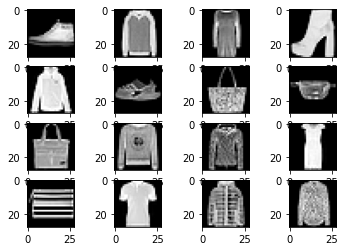

In [4]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(devxs))].reshape(28, 28))

In [21]:
# Hyperparameters
learning_rate = alpha = 0.01
epochs = 50
momentum_coefficient = 0.9

Din = trainxs[0].shape[0] # trainxs.shape == (12000, 748, 1)
h1 = 200
h2 = 20
Dout = 1

In [6]:
def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [7]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x) * (1 - sigmoid(x))
init_param = lambda shape: np.random.random(shape) / 100

class ThreeLayerPerceptron():
    def __init__(self, Din, h1, h2):
        self.Din = Din
        self.h1 = h1
        self.h2 = h2
        self.Dout = 1
        
        self.W1 = init_param((self.h1, self.Din))
        self.W2 = init_param((self.h2, self.h1))
        self.w3 = init_param((1, self.h2))
        self.b1 = init_param((self.h1, 1))
        self.b2 = init_param((self.h2, 1))
        self.b3 = init_param((self.Dout, self.Dout))
    
    def forward_old(self, x, W1=None, b1=None, W2=None, b2=None, w3=None, b3=None):
        """
        Parameters
        ----------
        x : np.array(Din, 1)
            Individual datapoint
        Returns
        -------
        ypred : np.array(1)
            Predicted Y
        """
        if W1 is None:
            W1 = self.W1
        if b1 is None:
            b1 = self.b1
        if W2 is None:
            W2 = self.W2
        if b2 is None:
            b2 = self.b2
        if w3 is None:
            w3 = self.w3
        if b3 is None:
            b3 = self.b3
        
        a1 = sigmoid(W1 @ x + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        ypred = a3 = sigmoid(w3 @ a2 + b3)
        return ypred

In [8]:
mlp = ThreeLayerPerceptron(Din, h1, h2)

In [9]:
def backward(x, y, m):
#     print(m.w3.shape, m.W2.shape, m.W1.shape) # (1, 20) (20, 200) (200, 784)
#     print(m.b3.shape, m.b2.shape, m.b1.shape) # (1, 1) (20, 1) (200, 1)
    z1 = m.W1 @ x + m.b1
    a1 = sigmoid(z1) # (200, 1)
    
    z2 = m.W2 @ a1 + m.b2
    a2 = sigmoid(z2) # (20, 1)
    
    z3 = m.w3 @ a2 + m.b3
    y_pred = a3 = sigmoid(z3) # (1, 1)
    
    dL_dz3 = loss_prime(y_pred, y) * sigmoid_prime(z3) # (1, 1)
    dL_dz2 = dL_dz3.dot(m.w3).T * sigmoid_prime(z2) # (20, 1)
    dL_dz1 = np.multiply(dL_dz2.T.dot(m.W2).T, sigmoid_prime(z1)) # (200, 1)
    # print(dL_dz3.shape, dL_dz2.shape, dL_dz1.shape)
    
    grad_w3 = dL_dz3.dot(a2.T) # (1, 20)
    grad_W2 = dL_dz2.dot(a1.T) # (20, 200)
    grad_W1 = dL_dz1.dot(x.T) # (784, 200)
    # print(grad_w3.shape, grad_W2.shape, grad_W1.shape)

    grad_b3 = dL_dz3 # (1, 1)
    grad_b2 = dL_dz2 # (20, 1)
    grad_b1 = dL_dz1 # (200, 1)
    # print(grad_b3.shape, grad_b2.shape, grad_b1.shape)
    
    return grad_w3, grad_W2, grad_W1, grad_b3, grad_b2, grad_b1

In [10]:
ci = 2
somex = trainxs[ci]
somey = trainys[ci]
grad_w3, grad_W2, grad_W1, grad_b3, grad_b2, grad_b1 = backward(somex, somey, mlp)

# Gradient Check

## $b_3$ grad

In [11]:
def fd_grad_b3(b3p, i, m):
    epsilon = 1e-6
    upper = loss(m.forward_old(trainxs[i], b3=(b3p + epsilon)), trainys[i])
    lower = loss(m.forward_old(trainxs[i], b3=(b3p - epsilon)), trainys[i])
    fd = (upper - lower) / (2 * epsilon)
    return fd
fd_grad_b3_i = fd_grad_b3(mlp.b3, ci, mlp)
(fd_grad_b3_i - grad_b3)

array([[3.65565911e-12]])

## $b_2$ grad

In [12]:
def fd_grad_b2(m, i):
    epsilon = 1e-6
    b2vec = m.b2.squeeze()
    x = trainxs[i]
    y = trainys[i]
    output = np.zeros_like(b2vec)
    for i in range(b2vec.size):
        b2vecu = b2vec.copy()
        b2vecl = b2vec.copy()
        b2vecu[i] += epsilon
        b2vecl[i] -= epsilon
        l = loss(m.forward_old(x, b2=b2vecu.reshape((-1, 1))), y)
        r = loss(m.forward_old(x, b2=b2vecl.reshape((-1, 1))), y)
        output[i] = ((l - r) / (2 * epsilon))
    return output.reshape(m.b2.shape)
fd_grad_b2_i = fd_grad_b2(mlp, ci)
print((fd_grad_b2_i - grad_b2).max())

6.336136478826933e-11


array([[ 1.73337690e-11],
       [ 3.39591268e-12],
       [-6.83677324e-12],
       [ 3.21942090e-11],
       [-8.19714998e-11],
       [-4.77141891e-11],
       [-2.22408564e-11],
       [-3.97582507e-11],
       [ 6.33613648e-11],
       [ 5.60534746e-11],
       [-1.43220822e-11],
       [-2.20625089e-11],
       [-3.00533041e-11],
       [-4.14755285e-11],
       [-3.26730547e-11],
       [-3.16548650e-11],
       [-1.56501270e-11],
       [-9.22166485e-11],
       [-5.39925281e-11],
       [ 2.38838418e-11]])

## $b_1$ grad

In [13]:
def fd_grad_b1(m, i):
    epsilon = 1e-6
    b1vec = m.b1.squeeze()
    x = trainxs[i]
    y = trainys[i]
    output = np.zeros_like(b1vec)
    for i in range(b1vec.size):
        b1vecu = b1vec.copy()
        b1vecl = b1vec.copy()
        b1vecu[i] += epsilon
        b1vecl[i] -= epsilon
        l = loss(m.forward_old(x, b1=b1vecu.reshape((-1, 1))), y)
        r = loss(m.forward_old(x, b1=b1vecl.reshape((-1, 1))), y)
        output[i] = ((l - r) / (2 * epsilon))
    return output.reshape(m.b1.shape)
fd_grad_b1_i = fd_grad_b1(mlp, ci)
print((fd_grad_b1(mlp, ci) - grad_b1).max())

1.6101180946213894e-11


array([[1.05980048e-11],
       [4.84454949e-12],
       [8.85239155e-12],
       [3.29543291e-12],
       [7.87906993e-12],
       [4.83928141e-12],
       [8.74659028e-12],
       [5.29134747e-12],
       [1.06397148e-11],
       [9.27990135e-12],
       [8.29933901e-12],
       [7.92204279e-12],
       [5.35137027e-12],
       [1.07460264e-11],
       [6.26854351e-12],
       [5.90716995e-12],
       [4.02113774e-12],
       [8.60986093e-12],
       [4.91092828e-12],
       [9.61002008e-12],
       [7.58089275e-12],
       [1.33836684e-11],
       [5.65148790e-12],
       [7.13129024e-12],
       [5.25016932e-12],
       [5.35420863e-12],
       [9.54368183e-12],
       [8.02794284e-12],
       [3.33205385e-12],
       [1.15595547e-11]])

## $w_3$ grad

In [17]:
def fd_grad_w3(m, i):
    epsilon = 1.e-6
    w3shape = m.w3.shape
    w3f = m.w3.copy().flatten()
    gradfd_w3f = w3f.copy()
    x = trainxs[i]
    y = trainys[i]
    for i in range(w3f.size):
        w3fupper = w3f.copy()
        w3flower = w3f.copy()
        w3fupper[i] += epsilon
        w3flower[i] -= epsilon
        
        w3upper = w3fupper.reshape(w3shape)
        w3lower = w3flower.reshape(w3shape)
        
        a1 = sigmoid(m.W1.dot(x) + m.b1)
        a2 = sigmoid(m.W2.dot(a1) + m.b2)
        
        a3upper = sigmoid(w3upper.dot(a2) + m.b3)
        a3lower = sigmoid(w3lower.dot(a2) + m.b3)
        upper = loss(a3upper, y)
        lower = loss(a3lower, y)
        
        fd = (upper - lower) / (2 * epsilon)
        gradfd_w3f[i] = fd
    
    gradfd_w3 = gradfd_w3f.reshape(w3shape)
    return gradfd_w3
fd_grad_w3_i = fd_grad_w3(mlp, ci)
print((fd_grad_w3_i - grad_w3).max())

5.344788500671882e-11
[[-5.97228933e-11 -2.65470979e-11  3.96023769e-11 -8.74861295e-12
  -3.82268384e-11  1.07716613e-12 -1.24632249e-11  4.95279373e-11
  -1.00216779e-10 -4.64023819e-11 -1.46625490e-11  5.34478850e-11
   9.34266553e-12  2.48012721e-11 -1.02971520e-11 -8.55700510e-11
  -5.53281587e-11 -3.66695563e-12  1.52421686e-11 -1.11341492e-12]]


## $W_2$ grad

In [15]:
def fd_grad_W2(m, i):
    epsilon = 1e-6
    W2vec = m.W2.flatten()
    W2shape = m.W2.shape
    x = trainxs[i]
    y = trainys[i]
    
    output = np.zeros_like(W2vec)
    for i in range(W2vec.size):
        # Upper
        W2vecp = W2vec.copy()
        W2vecp[i] += epsilon
        upper = loss(m.forward_old(x, W2=(W2vecp.reshape(W2shape))), y)
        
        # Lower
        W2vecp = W2vec.copy()
        W2vecp[i] -= epsilon
        lower = loss(m.forward_old(x, W2=(W2vecp.reshape(W2shape))), y)
        
        output[i] = ((upper - lower) / (2 * epsilon))
    return output.reshape(W2shape)
fd_grad_W2_i = fd_grad_W2(mlp, ci)
print((fd_grad_W2_i - grad_W2).max())

8.23632050318227e-11


array([[-9.75229636e-13,  8.96483434e-12,  6.98576915e-14, ...,
         5.08867149e-12,  6.00893683e-12,  5.39695891e-12],
       [-2.28683844e-12,  7.98360850e-13, -1.96246400e-12, ...,
        -4.04723447e-13, -1.19091286e-13, -3.09037130e-13],
       [-2.21263308e-11, -1.38255393e-11, -2.12535947e-11, ...,
        -1.70624621e-11, -1.62939629e-11, -1.68050161e-11],
       ...,
       [-9.44746025e-11, -9.32487459e-11, -9.43457173e-11, ...,
        -9.37267730e-11, -9.36132814e-11, -9.36887535e-11],
       [-7.09793136e-11, -6.17570870e-11, -7.00096989e-11, ...,
        -6.53533266e-11, -6.44995197e-11, -6.50673027e-11],
       [ 3.98386507e-12,  1.47876805e-11,  5.11976627e-12, ...,
         1.05746947e-11,  1.15749274e-11,  1.09097711e-11]])

## $W_1$ grad

In [19]:
def fd_grad_W1(m, i):
    epsilon = 1e-6
    W1vec = m.W1.flatten()
    W1shape = m.W1.shape
    x = trainxs[i]
    y = trainys[i]
    
    output = np.zeros_like(W1vec)
    W1vecp = np.zeros_like(W1vec)
    for i in range(W1vec.size):
        # Upper
        W1vecp[:] = W1vec
        W1vecp[i] += epsilon
        upper = loss(m.forward_old(x, W1=(W1vecp.reshape(W1shape))), y)
        
        # Lower
        W1vecp[:] = W1vec
        W1vecp[i] -= epsilon
        lower = loss(m.forward_old(x, W1=(W1vecp.reshape(W1shape))), y)
        
        output[i] = ((upper - lower) / (2 * epsilon))
    return output.reshape(W1shape)
fd_grad_W1_i = fd_grad_W1(mlp, ci)
print((fd_grad_W1_i - grad_W1).max())

1.6101180946213894e-11


# 3.3 *The* Algorithm

In [35]:
def predict(x, m):
    if m.forward_old(x) >= 0.5:
        return 1
    return 0

In [44]:
def accuracy(xs, ys, m):
    correct = 0
    for i in range(xs.shape[0]):
        y_pred = predict(xs[i], m)
        if y_pred == ys[i]:
            correct += 1
    return correct / (xs.shape[0]) * 100

In [48]:
def deepcopy(m):
    retm = ThreeLayerPerceptron(m.Din, m.h1, m.h2)
    retm.w3 = m.w3
    retm.W2 = m.W2
    retm.W1 = m.W1
    retm.b3 = m.b3
    retm.b2 = m.b2
    retm.b1 = m.b1
    return retm

In [67]:
def train(xs, ys, m):
    bestm = deepcopy(m)
    bestacc = 0.0
    
    for iteration in range(epochs):
        p = np.random.permutation(xs.shape[0])
        xs_shuffled = xs[p]
        ys_shuffled = ys[p]
        
        batches = [[i for i in range(xs_shuffled.shape[0])]]
        
        for batch in batches:
            grad_w3 = np.zeros_like(m.w3)
            grad_W2 = np.zeros_like(m.W2)
            grad_W1 = np.zeros_like(m.W1)
            
            grad_b3 = np.zeros_like(m.b3)
            grad_b2 = np.zeros_like(m.b2)
            grad_b1 = np.zeros_like(m.b1)
            
            for i in batch:
                x = xs_shuffled[i]
                y = ys_shuffled[i]
                
                y_pred = m.forward_old(x)
                
                grad_w3p, grad_W2p, grad_W1p, grad_b3p, grad_b2p, grad_b1p = backward(x, y, m)
                
                grad_w3 -= grad_w3p
                grad_W2 -= grad_W2p
                grad_W1 -= grad_W1p
                grad_b3 -= grad_b3p
                grad_b2 -= grad_b2p
                grad_b1 -= grad_b1p
                
            grad_w3 /= len(batch)
            grad_W2 /= len(batch)
            grad_W1 /= len(batch)
            grad_b3 /= len(batch)
            grad_b2 /= len(batch)
            grad_b1 /= len(batch)
            
            m.w3 += learning_rate * grad_w3
            m.W2 += learning_rate * grad_W2
            m.W1 += learning_rate * grad_W1
            m.b3 += learning_rate * grad_b3
            m.b2 += learning_rate * grad_b2
            m.b1 += learning_rate * grad_b1
            
        acc = accuracy(devxs, devys, m)
        if acc > bestacc:
            bestm = deepcopy(m)
            bestacc = acc
        print("Iteration", iteration)
        print("Current Accuracy: {}, Best Accuracy: {}".format(acc, bestacc))
    m = deepcopy(bestm)
#     return bestm

In [68]:
m = ThreeLayerPerceptron(Din, h1, h2)

In [69]:
train(trainxs[:1000], trainys[:1000], m)

Iteration 0
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 1
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 2
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 3
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 4
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 5
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 6
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 7
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 8
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 9
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 10
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 11
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 12
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 13
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 14
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 15
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 16
Current Accuracy: 50.5, Best Accuracy: 50.5
Iteration 17
Current Accuracy: 50.5, Best